## US Border Patrol Basic Analysis

To do list:
- Make flexible parameters for analysis: (Demographic/sector/nationality)

CBP Website for reference:  
https://www.cbp.gov/newsroom/stats/southwest-land-border-encounters

### Important:
To get this file to work you must have the following libraries installed:
- pandas
- openpyxl
- seaborn  
  
You must also have the excel file "USBP SBO Encounters by Sector Citiz Group Demo FY13-FY21TD-FEB.xlsx" downloaded in the same folder as this notebook  
  
If you are unfamiliar with python here is a guide on pip installing:
- https://docs.python.org/3/installing/index.html  
  
### Inputs

In [2]:
PAST_YEARS = 3   # How many of the past years should be taken into account for the forecastin
GRAPH_YEARS = 5  # How many years should be displayed on graphs

### Importing and Formatting Data

In [3]:
# import the necessary libraries used in the code

import pandas as pd              # for dataframes
import openpyxl                  # for reading in excel files
import seaborn as sns            # for nice graphs
import matplotlib.pylab as plt   # to help with graphs
import numpy as np
import datetime

In [4]:
# read in the data file
filename = "USBP SBO Encounters by Sector Citiz Group Demo FY13-FY21TD-FEB.xlsx"
df = pd.read_excel(filename, header=6,usecols="B:G", engine='openpyxl')
df.head()

,FY,Month,Sector,Citizenship Grouping,Demographic,Count
0,FY2013,APR,LRT,Mexico,FMUA,70
1,FY2013,AUG,ELC,Mexico,FMUA,10
2,FY2013,AUG,RGV,Mexico,FMUA,186
3,FY2013,AUG,TCA,Mexico,FMUA,136
4,FY2013,DEC,EPT,Mexico,FMUA,30


Switched from strings to integers for months to make calculations easier.  
In order to get the dates to process in the right order, 1=October or the first month in the fiscal year

In [5]:
# months are placed into a list starting with OCT becasue it is the start of the fiscal year,
# which the data uses instead of calendar year.  The months are then mapped to digits starting
# with OCT as 1, NOV as 2, DEC as 3, and so on up to SEP as 12.  Column 'M' is added to the
# dataframe representing the numerical value of the month that was previously assigned. In the
# 'FY' column, the FY is removed from the value so it is represented soley numerically. Changing
# these values to numbers rather than letters or a mix of letters and numbers
# makes it easier to conduct the analysis on the data.
months = ['OCT','NOV','DEC','JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP']
month_map = {month:i+1 for i,month in enumerate(months)}
df["Month"] = df["Month"].map(month_map)
df["year"] = df["FY"].apply(lambda x:int(x[2:6]))
df.head()

,FY,Month,Sector,Citizenship Grouping,Demographic,Count,year
0,FY2013,7,LRT,Mexico,FMUA,70,2013
1,FY2013,11,ELC,Mexico,FMUA,10,2013
2,FY2013,11,RGV,Mexico,FMUA,186,2013
3,FY2013,11,TCA,Mexico,FMUA,136,2013
4,FY2013,3,EPT,Mexico,FMUA,30,2013


In [7]:
# data is summed by demographic, fiscal year, and month to consolidate similar data entries into 
# one count.  This way there is one entry for each demographic for every month of each fiscal year
# instead of multiple entries with very similar information.  A new column 'Date' is added to the
# dataframe in order for the user to quickly identify the year and month.
sum_df = df.groupby(["Demographic","year","Month"]).sum().reset_index()
sum_df["day"] = 1
sum_df["Date"] = pd.to_datetime(sum_df[["year","Month","day"]])
sum_df.drop(["day"], axis=1,inplace=True)
sum_df = sum_df.rename(columns={"Month":"M","year":"FY"})

,Demographic,FY,M,Count,Date
0,FMUA,2013,1,799,2013-01-01
1,FMUA,2013,2,776,2013-02-01
2,FMUA,2013,3,746,2013-03-01
3,FMUA,2013,4,847,2013-04-01
4,FMUA,2013,5,923,2013-05-01
...,...,...,...,...,...
298,UAC / Single Minors,2021,1,4690,2021-01-01
299,UAC / Single Minors,2021,2,4476,2021-02-01
300,UAC / Single Minors,2021,3,4853,2021-03-01
301,UAC / Single Minors,2021,4,5694,2021-04-01


#### Create Total Column across Demographics

In [8]:
for row_idx, row in sum_df.iterrows():
    row_month, row_year = row[["M","FY"]]
    
    other_months = sum_df.loc[(sum_df["M"] == row_month) 
                              & (sum_df["FY"] == row_year) 
                              & (sum_df["Demographic"] != "Total")]["Count"]
    if sum_df.loc[(sum_df["M"] == row_month) & (sum_df["FY"] == row_year) & (sum_df["Demographic"] == "Total")].empty:
        new_row = {'Demographic':'Total','FY':row_year,'M':row_month,'Count':sum(other_months),'Date':row["Date"]}
        sum_df = sum_df.append(new_row, ignore_index=True)

In [35]:
sum_df

,Demographic,FY,M,Count,Date,% Change,% Predicted,Count Predicted,% Error
0,FMUA,2013,1,799,2013-01-01,0.00,0.00,0,100.00
1,FMUA,2013,2,776,2013-02-01,-2.88,0.00,799,-2.96
2,FMUA,2013,3,746,2013-03-01,-3.87,-2.88,754,-1.07
3,FMUA,2013,4,847,2013-04-01,13.54,-3.87,717,15.35
4,FMUA,2013,5,923,2013-05-01,8.97,13.54,962,-4.23
...,...,...,...,...,...,...,...,...,...
399,Total,2021,1,69046,2021-01-01,26.06,2.11,55927,19.00
400,Total,2021,2,69162,2021-02-01,0.17,12.14,77428,-11.95
401,Total,2021,3,71142,2021-03-01,2.86,-1.15,68367,3.90
402,Total,2021,4,75312,2021-04-01,5.86,-0.42,70843,5.93


### Current Analysis  

- % Change = the (current month - previous month) / previous month
- Predicted = averaging the % Change from the past three years
- Error = The difference between the actual and the predicted totals

In [10]:
# This cell calculates the month to month percent change in data.  After we have aggregated the
# data into one entry for each month, the percent change is calculated by taking the difference
# between the current month and the previous month, then dividing by the previous month's numbers.
# A percent change column is added to the dataframe with the corresponding values.  A negative 
# percent change means the previous month's total was higher than the current month's total.
def PercChange(df, row_idx, row):
    row_demographic, row_month, row_year = row[["Demographic","M","FY"]]

    if row_month != 1:
        previous_month = df.loc[(df["Demographic"]==row_demographic) 
                                & (df["M"] == row_month-1) 
                                & (df["FY"] == row_year)]
    else:
        previous_month = df.loc[(df["Demographic"]==row_demographic) 
                                & (df["M"] == 12)
                                & (df["FY"] == row_year-1)]

    if not previous_month.empty:
        return round(float((row["Count"]-previous_month["Count"])/previous_month["Count"]),4)*100
    return 0

In [11]:
# Calculations for the percent change prediction.  Calculated by averageing the previous month's
# change with the previous two year's changes.  For example, predicting Jan to Feb 2021 change
# would require averaging the previous Dec to Jan prediction with the Dec to Jan prediction from
# 2020 and 2019.  If the data does not go back far enough, only the available data is used.  The
# percent change predicted is then used to make the predicted count for the month.

# this cell will be simplified and commented on more for the future
def Predict(df, row_idx, row, PAST_YEARS=5):
    row_demographic, row_month, row_year = row[["Demographic","M","FY"]]
    
    changes = list()
    for year in range(PAST_YEARS):
        if row_month != 1:
            year_change = df.loc[(sum_df["Demographic"]==row_demographic)
                                     & (df["M"]==row_month-1) 
                                     & (df["FY"]==row_year-year)]
        else:
            year_change = df.loc[(df["Demographic"]==row_demographic)
                                    &  (df["M"]==12) 
                                    & (df["FY"]==(row_year-1-year))]
        
        if not year_change["% Change"].empty and year_change["% Change"].item() != 0:
                changes.append(year_change["% Change"].item())

    if len(changes) != 0:
        return round(sum(changes)/len(changes),2)
    return 0

In [12]:
# New comment sabout how this uses the predicted percent and courrent count to forecast next count

def Forecast(df, row_idx, row):
    row_demographic, row_month, row_year = row[["Demographic","M","FY"]]
    
    if row_month != 1:
        previous_month = df.loc[(df["Demographic"]==row_demographic) 
                                & (df["M"] == row_month-1) 
                                & (df["FY"] == row_year)]
    else:
        previous_month = df.loc[(df["Demographic"]==row_demographic) 
                                & (df["M"] == 12)
                                & (df["FY"] == row_year-1)]
        
    if not previous_month["Count"].empty:
        return round((1+row["% Predicted"]/100)*previous_month["Count"].item())
    return 0

In [13]:
# applying the functions to the rows of data

sum_df["% Change"] = 0
sum_df["% Predicted"] = 0
sum_df["Count Predicted"] = 0
for row_idx, row in sum_df.iterrows():
    sum_df.loc[[row_idx],["% Change"]] = PercChange(sum_df, row_idx, row)
    
    predict = Predict(sum_df, row_idx, row, PAST_YEARS)
    sum_df.loc[[row_idx],["% Predicted"]] = predict
    row["% Predicted"] = predict
    
    sum_df.loc[[row_idx],["Count Predicted"]] = Forecast(sum_df, row_idx, row)

sum_df["% Error"] = round(100*(sum_df["Count"]-sum_df["Count Predicted"])/sum_df["Count"],2)

In [14]:
# Another column is added to the dataframe for the error measurement of the predicted change.  The
# error is calculated by subtracting the predicted value from the actual value and dividing by the
# actual value.  A negative error means that the predicted value was higher than the actual value.

### Example By hand

In [15]:
sum_df[sum_df['M']<=3].head(9)

,Demographic,FY,M,Count,Date,% Change,% Predicted,Count Predicted,% Error
0,FMUA,2013,1,799,2013-01-01,0.00,0.00,0,100.00
1,FMUA,2013,2,776,2013-02-01,-2.88,0.00,799,-2.96
2,FMUA,2013,3,746,2013-03-01,-3.87,-2.88,754,-1.07
12,FMUA,2014,1,2414,2014-01-01,23.99,2.10,1988,17.65
13,FMUA,2014,2,2786,2014-02-01,15.41,23.99,2993,-7.43
14,FMUA,2014,3,3311,2014-03-01,18.84,6.26,2960,10.60
24,FMUA,2015,1,2162,2015-01-01,-6.04,-14.04,1978,8.51
25,FMUA,2015,2,2415,2015-02-01,11.70,8.98,2356,2.44
26,FMUA,2015,3,2891,2015-03-01,19.71,8.08,2610,9.72


Displayed above are the first three months of 2013, 2014, 2015  
Looking at the FMUA Demographic in 2015 lets predict Month 3 (December), using the past three years of data:  
October to November 2015 = 11.70% change  
October to November 2014 = 15.41% change  
October to November 2013 = -02.88% change  
11.70 + 15.41 - 2.88 = 24.23/3 = 8.08 % change on average from October to November  
  
1+(8.08/100) = 1.0808 (% change in decimal)  
November 2015 count = 2415 (Most recent month)  
2415*1.0808 = 2610 people predicted for December  
Actual count was 2891 which was a 9.72% error  

### Pivot Tables for each of the new values
These are tables of specific data such as Count, % Change, etc. at a glance

In [16]:
# This pivot table separates the values by demographic.  The demographics are the x-axis and the
# year/month are the y-axis.
counts=sum_df.pivot(index="Date",columns="Demographic",values="Count")
counts.head()

Demographic,FMUA,Single Adults,Total,UAC / Single Minors
Date,,,,
2013-01-01,799,25797,28929,2333
2013-02-01,776,24468,27636,2392
2013-03-01,746,20279,23243,2218
2013-04-01,847,23814,26921,2260
2013-05-01,923,31133,35042,2986


In [17]:
# This pivot table shows the month to month percent change for each demographic, with the same
# axis labels as before.
percents=sum_df.pivot(index="Date",columns="Demographic",values="% Change")
percents.head()

Demographic,FMUA,Single Adults,Total,UAC / Single Minors
Date,,,,
2013-01-01,0.00,0.00,0.00,0.00
2013-02-01,-2.88,-5.15,-4.47,2.53
2013-03-01,-3.87,-17.12,-15.90,-7.27
2013-04-01,13.54,17.43,15.82,1.89
2013-05-01,8.97,30.73,30.17,32.12


In [18]:
# Here we have the predicted values in the pivot table, again same axis labels are used.
prediction=sum_df.pivot(index="Date",columns="Demographic",values="Count Predicted")
prediction.head()

Demographic,FMUA,Single Adults,Total,UAC / Single Minors
Date,,,,
2013-01-01,0,0,0,0
2013-02-01,799,25797,28929,2333
2013-03-01,754,23208,26401,2453
2013-04-01,717,16807,19547,2057
2013-05-01,962,27965,31180,2303


In [19]:
# pivot table with the error values, same axis labels.
error=sum_df.pivot(index="Date",columns="Demographic",values="% Error")
error.head()

Demographic,FMUA,Single Adults,Total,UAC / Single Minors
Date,,,,
2013-01-01,100.00,100.00,100.00,100.00
2013-02-01,-2.96,-5.43,-4.68,2.47
2013-03-01,-1.07,-14.44,-13.59,-10.60
2013-04-01,15.35,29.42,27.39,8.98
2013-05-01,-4.23,10.18,11.02,22.87


## Plots
We limit the entries we graph according to the GRAPH_YEARS input

In [20]:
most_recent_entry_date = pd.to_datetime(str(max(sum_df.loc[sum_df['FY']==max(sum_df['FY']),"M"]))+" "+str(max(sum_df['FY'])))

graph_df = sum_df.loc[sum_df['Date'] >= pd.to_datetime(
    str(most_recent_entry_date.month) + " " + str(most_recent_entry_date.year-GRAPH_YEARS), format="%m %Y")]
                      
inv_month_map = {integer: month for month, integer in month_map.items()}

graph_df.head()

,Demographic,FY,M,Count,Date,% Change,% Predicted,Count Predicted,% Error
40,FMUA,2016,5,3050,2016-05-01,-2.96,-46.61,1678,44.98
41,FMUA,2016,6,4451,2016-06-01,45.93,22.13,3725,16.31
42,FMUA,2016,7,5620,2016-07-01,26.26,52.52,6789,-20.80
43,FMUA,2016,8,6783,2016-08-01,20.69,16.81,6565,3.21
44,FMUA,2016,9,6627,2016-09-01,-2.30,47.31,9992,-50.78


Creating forecasts for future dates

In [21]:
for category in sum_df["Demographic"].unique():
    row  = sum_df.loc[(sum_df["Demographic"]==category) 
                        & (sum_df["M"] == most_recent_entry_date.month)
                        & (sum_df["FY"] == most_recent_entry_date.year)]
    row = sum_df.iloc[row.index.values[0]]
    
    value1 = Predict(sum_df, row.index, row, PAST_YEARS=5)
    value2 = Forecast(sum_df, row.index, row)
    
    if row["M"]!=12:
        new_date = pd.to_datetime(str(row["M"]+1) + " " + str(row["FY"]), format="%m %Y")
    else:
        new_date = pd.to_datetime("1 " + str(row["FY"]+1), format="%m %Y")
    
    new_row = {'Demographic':category, 'FY':new_date.year, 'M':new_date.month, 'Count':np.nan, 'Date':new_date,
          '% Change':np.nan, '% Predicted':value1, 'Count Predicted': value2, '% Error':np.nan}
    graph_df = graph_df.append(new_row, ignore_index=True)

### Plots of the Counts for each Month

<AxesSubplot:xlabel='Date', ylabel='Count'>

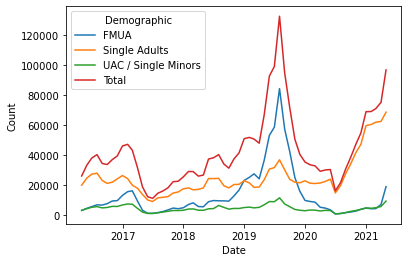

In [22]:
# this plot shows the predicted counts for each demographic, year-to-year.
sns.lineplot(data=graph_df,x="Date",y="Count",hue="Demographic")

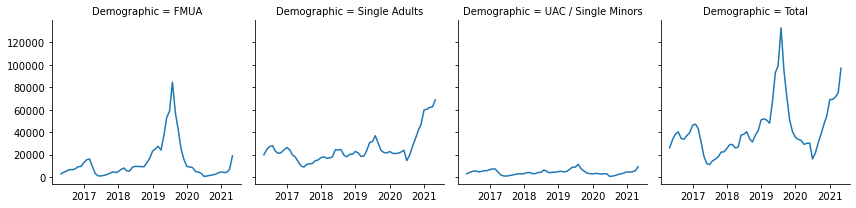

In [23]:
# these graphs are the same as the previous one, the predicted counts for each month, but instead
# of all three demographics overlayed on one graph, they are separated into three different graphs
g = sns.FacetGrid(graph_df, col="Demographic")
g.map_dataframe(sns.lineplot,x="Date",y="Count")

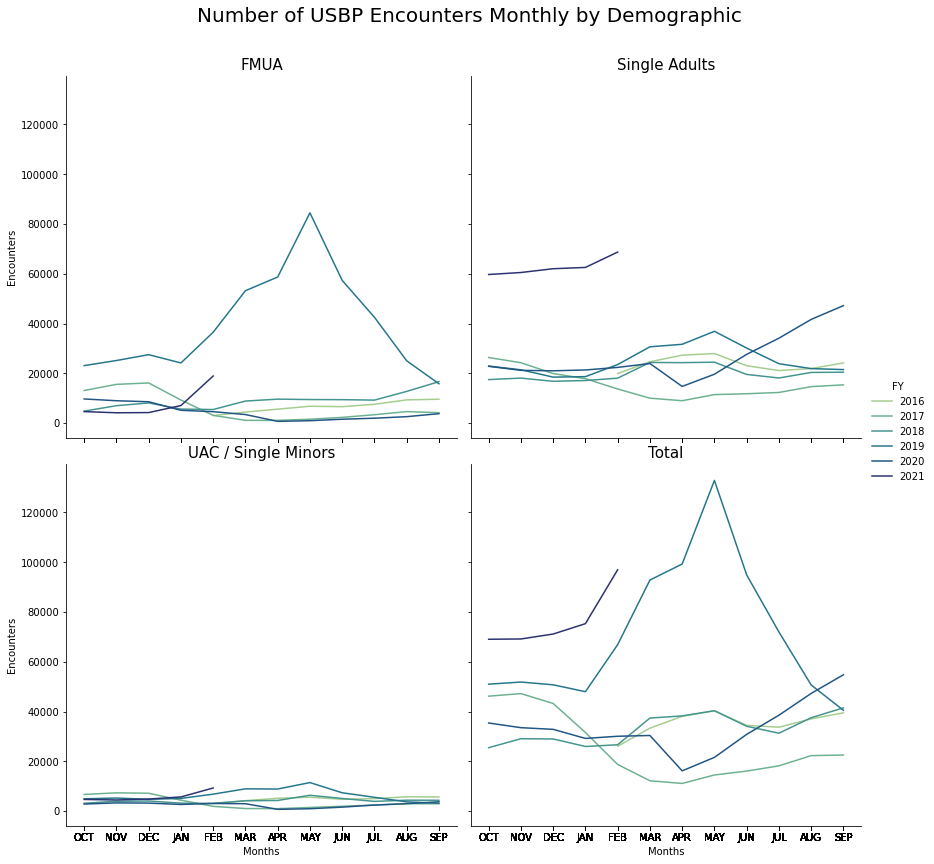

In [24]:
# These graphs show the month-to-month predicted counts for the three demographics.  The darker
# lines or the more recent year's values (the darker the line, the more recent the data is).  The 
# month are represented on the x-axis by their fiscal year numerical value (OCT=1, NOV=2, etc.)
palette = sns.color_palette("crest", as_cmap=True)
g = sns.FacetGrid(graph_df, col="Demographic", col_wrap=2,height=6,aspect=1) 
g.map_dataframe(sns.lineplot,x="M",y="Count",hue="FY", palette=palette)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Number of USBP Encounters Monthly by Demographic', size=20)
g.set_titles(col_template="{col_name}", size=15)


g.set(xticks=graph_df.M)
ax = plt.gca()
xticks = ax.get_xticks()
ax.set_xticklabels([inv_month_map[i] for i in xticks])

g.add_legend(title = "FY")
g.set_axis_labels("Months", "Encounters")

### Plots of the  Percent Change each Month

<AxesSubplot:xlabel='Date', ylabel='% Change'>

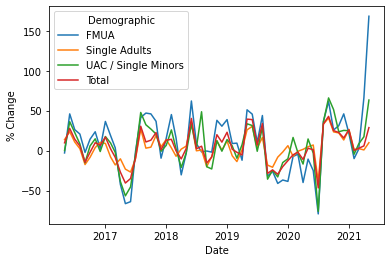

In [25]:
# this plot shows the percent change for each demographic, year-to-year.
sns.lineplot(data=graph_df,x="Date",y="% Change",hue="Demographic")

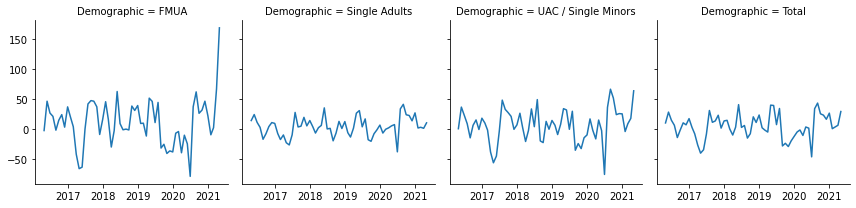

In [26]:
# these graphs are the same as the previous one, the percent change for each month, but instead
# of all three demographics overlayed on one graph, they are separated into three different graphs
g = sns.FacetGrid(graph_df, col="Demographic")
g.map_dataframe(sns.lineplot,x="Date",y="% Change")

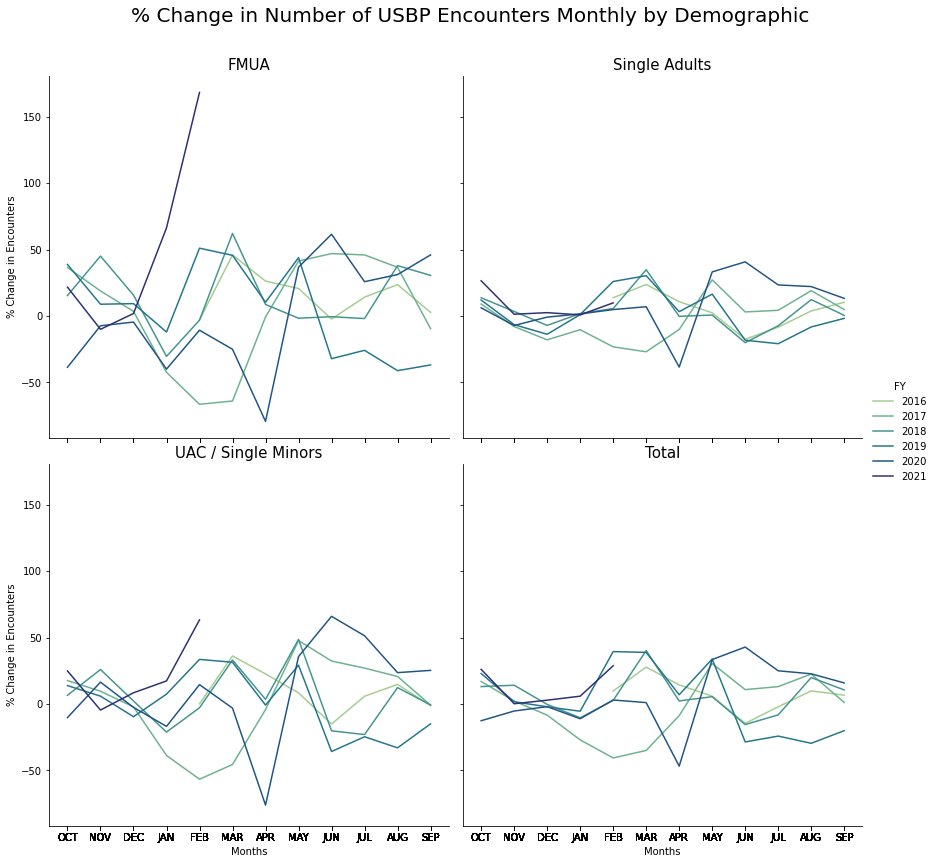

In [27]:
# These graphs show the month-to-month percent changes for the three demographics.  The darker
# lines or the more recent year's values (the darker the line, the more recent the data is).  The 
# month are represented on the x-axis by their fiscal year numerical value (OCT=1, NOV=2, etc.)
palette = sns.color_palette("crest", as_cmap=True)
g = sns.FacetGrid(graph_df, col="Demographic", col_wrap=2,height=6,aspect=1)
g.map_dataframe(sns.lineplot,x="M",y="% Change",hue="FY",palette=palette,legend='full')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('% Change in Number of USBP Encounters Monthly by Demographic', size=20)
g.set_titles(col_template="{col_name}", size=15)


g.set(xticks=graph_df.M)
ax = plt.gca()
xticks = ax.get_xticks()
ax.set_xticklabels([inv_month_map[i] for i in xticks])

g.add_legend(title = "FY")
g.set_axis_labels("Months", "% Change in Encounters")

### Different Plots of Error each Month

<AxesSubplot:xlabel='Date', ylabel='% Error'>

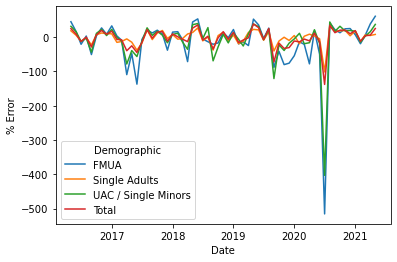

In [28]:
# this plot shows the error calculation for each demographic, year-to-year.
sns.lineplot(data=graph_df,x="Date",y="% Error",hue="Demographic")

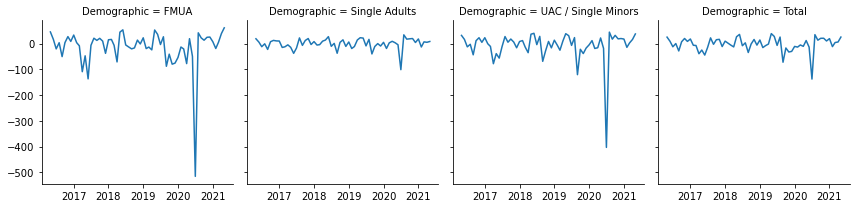

In [29]:
# these graphs are the same as the previous one, the error calculation for each month, but instead
# of all three demographics overlayed on one graph, they are separated into three different graphs
g = sns.FacetGrid(graph_df, col="Demographic")
g.map_dataframe(sns.lineplot,x="Date",y="% Error")

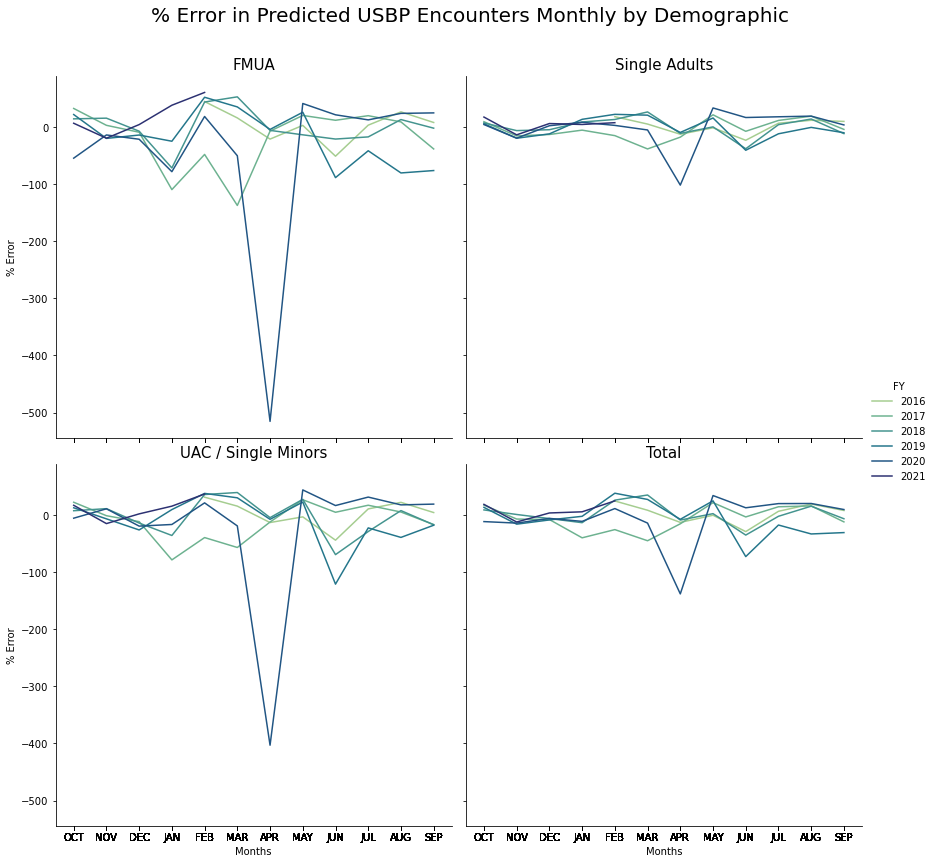

In [30]:
# These graphs show the month-to-month error calculation for the three demographics.  The darker
# lines or the more recent year's values (the darker the line, the more recent the data is).  The 
# month are represented on the x-axis by their fiscal year numerical value (OCT=1, NOV=2, etc.)
palette = sns.color_palette("crest", as_cmap=True)
g = sns.FacetGrid(graph_df, col="Demographic", col_wrap=2,height=6,aspect=1)
g.map_dataframe(sns.lineplot,x="M",y="% Error",hue="FY",palette=palette,legend='full')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('% Error in Predicted USBP Encounters Monthly by Demographic', size=20)
g.set_titles(col_template="{col_name}", size=15)


g.set(xticks=graph_df.M)
ax = plt.gca()
xticks = ax.get_xticks()
ax.set_xticklabels([inv_month_map[i] for i in xticks])

g.add_legend(title = "FY")
g.set_axis_labels("Months", "% Error")

### Plots of the Actual and Predicted Counts by Demographic and Year

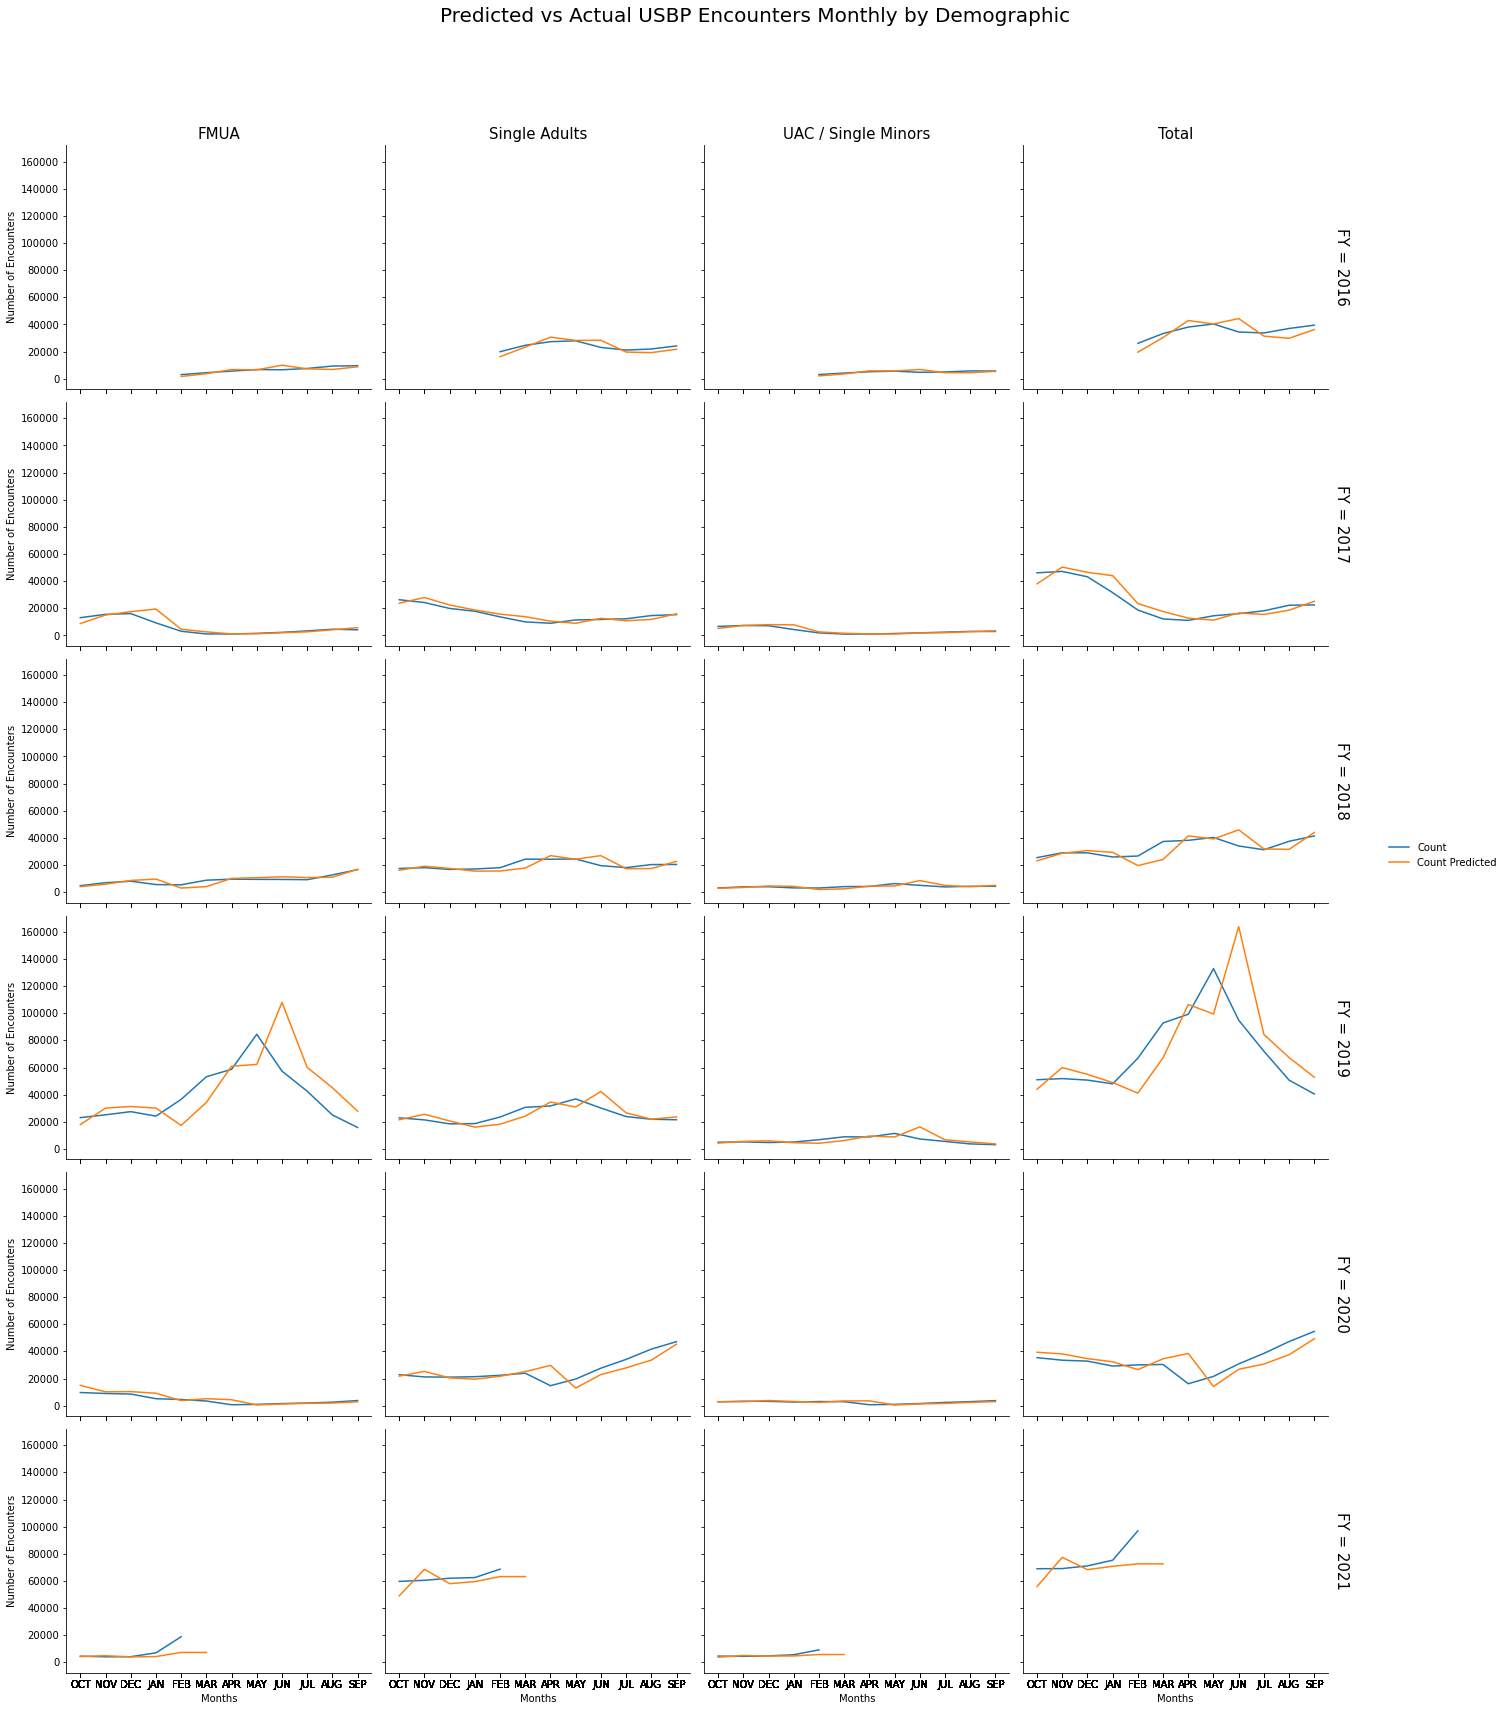

In [31]:
# the following graphs show the count in blue and the predicted count in orange.  We can see how
# good the predictions were based on how close the lines are together.  The x-axis has the months
# represented by their numerical value, and the y axis has the counts.  Each row of graphs
# represents a different fiscal year, and each column represents a different demographic.
melted_df = pd.melt(graph_df, id_vars=['Demographic','FY','M'], value_vars=['Count', 'Count Predicted'])
g = sns.FacetGrid(melted_df, col="Demographic", row="FY",height=4,aspect=1.2,margin_titles=True)
g = g.map_dataframe(sns.lineplot,x="M",y="value",hue="variable")
g.add_legend()

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Predicted vs Actual USBP Encounters Monthly by Demographic', size=20)
g.set_titles(col_template="{col_name}", size=15)


g.set(xticks=graph_df.M)
ax = plt.gca()
xticks = ax.get_xticks()
ax.set_xticklabels([inv_month_map[i] for i in xticks])

g.set_axis_labels("Months", "Number of Encounters")

### Main Report Graph

In [32]:
report_df  = graph_df.loc[graph_df['Date'] >= pd.to_datetime(
    str(most_recent_entry_date.month) + " " + str(most_recent_entry_date.year-1), format="%m %Y")]

melted_df = pd.melt(report_df, id_vars=['Demographic','Date'], value_vars=['Count', 'Count Predicted'])

Exact numbers of the past year of counts and predictions

In [33]:
report_df.pivot(index="Date",columns="Demographic",values=["Count","Count Predicted"])

Count                                             \
Demographic     FMUA Single Adults    Total UAC / Single Minors   
Date                                                              
2020-05-01    4610.0       22397.0  30077.0              3070.0   
2020-06-01    3455.0       23960.0  30389.0              2974.0   
2020-07-01     716.0       14754.0  16182.0               712.0   
2020-08-01     979.0       19648.0  21593.0               966.0   
2020-09-01    1581.0       27652.0  30836.0              1603.0   
2020-10-01    1989.0       34121.0  38536.0              2426.0   
2020-11-01    2609.0       41676.0  47283.0              2998.0   
2020-12-01    3808.0       47207.0  54771.0              3756.0   
2021-01-01    4634.0       59722.0  69046.0              4690.0   
2021-02-01    4170.0       60516.0  69162.0              4476.0   
2021-03-01    4248.0       62041.0  71142.0              4853.0   
2021-04-01    7064.0       62554.0  75312.0              5694.0   
2021-05-01   18945.0       68732.0  96974.0              9297.0   
2021-06-01       NaN           NaN      NaN                 NaN   

            Count Predicted                                             
Demographic            FMUA Single Adults    Total UAC / Single Minors  
Date                                                                    
2020-05-01           3743.0       21680.0  26579.0              2407.0  
2020-06-01           5182.0       25116.0  34595.0              3533.0  
2020-07-01           4407.0       29720.0  38500.0              3582.0  
2020-08-01            572.0       13013.0  14158.0               538.0  
2020-09-01           1237.0       22945.0  26829.0              1332.0  
2020-10-01           1733.0       27879.0  30706.0              1656.0  
2020-11-01           1976.0       33575.0  37588.0              2456.0  
2020-12-01           2852.0       45318.0  49335.0              3027.0  
2021-01-01           4312.0       49086.0  55927.0              3876.0  
2021-02-01           4972.0       68609.0  77428.0              5135.0  
2021-03-01           4052.0       58035.0  68367.0              4741.0  
2021-04-01           4342.0       59547.0  70843.0              4792.0  
2021-05-01           7400.0       63273.0  72623.0              5844.0  
2021-06-01           7400.0       63273.0  72623.0              5844.0

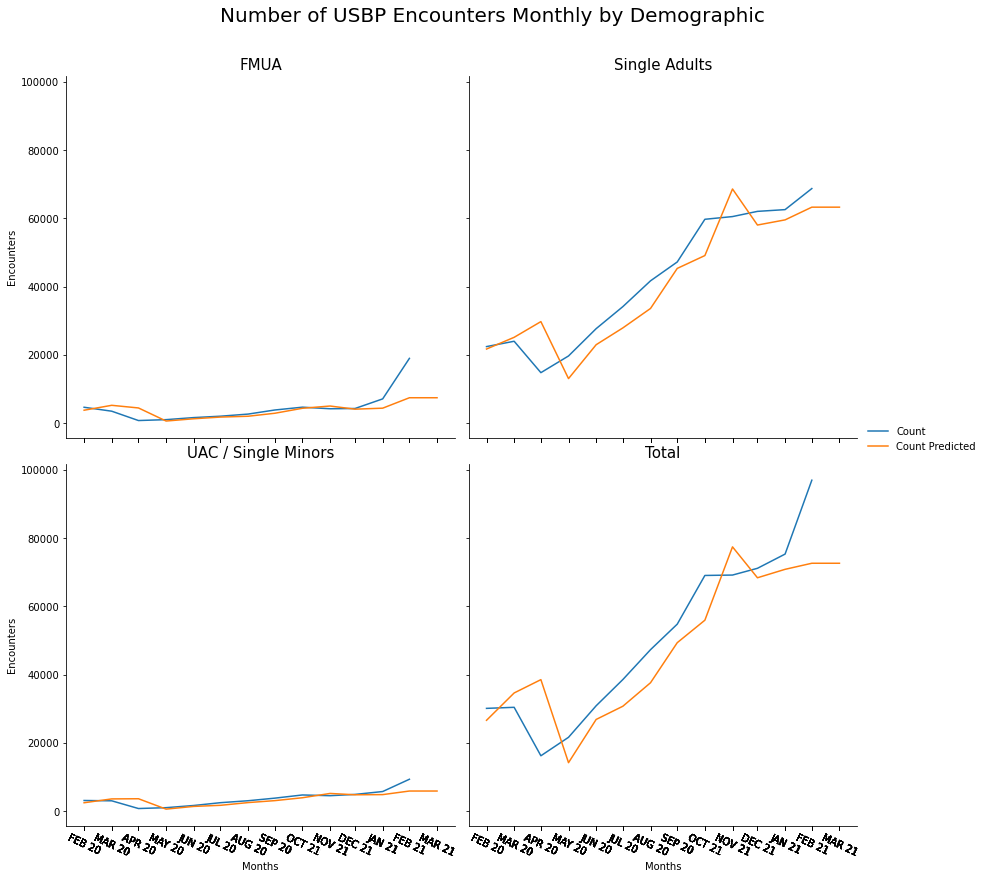

In [34]:
g = sns.FacetGrid(melted_df, col="Demographic", col_wrap=2,height=6,aspect=1)
g = g.map_dataframe(sns.lineplot,x="Date",y="value",hue="variable")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Number of USBP Encounters Monthly by Demographic', size=20)
g.set_titles(col_template="{col_name}", size=15)

values= melted_df["Date"].apply(lambda x: inv_month_map[x.month] + " " + str(x.year)[2:])
plt.xticks(melted_df["Date"],values)
plt.rcParams['font.weight'] = "regular"
[plt.setp(ax.get_xticklabels(), rotation=-25, fontweight = 10) for ax in g.axes.flat]

g.add_legend()
g.set_axis_labels("Months", "Encounters")